# `trace` cli

This is essentially a demo on a single cli tool, `trace`. It allows you to inspect the stream at every point around the (likely tangled) cli operations. Let's get into it.

In [1]:
from k1lib.imports import *

Let's start simple. Say you have an operation that calculates square of a list of numbers, like this:

In [2]:
range(1, 5) | apply(op()**2) | deref()

[1, 4, 9, 16]

For more complex operations, it can be easy to lose track of what's what, and how the stream should look like at a particular point. So, you can just slide a `trace()` in the middle:

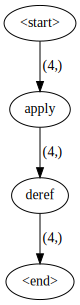

<trace object>

In [3]:
range(1, 5) | trace() | apply(lambda x: x**2) | deref()

With no arguments, this will get the shape of the stream. You can of course, pass in other displaying functions that you like. I typically just use `iden()`:

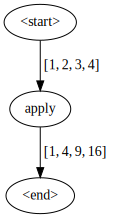

<trace object>

In [4]:
range(1, 5) | trace(iden()) | apply(lambda x: x**2)

Notice how I left out the last `deref()`. It's because it's only there to display the final value to us. But we already got that data from `trace()`, so we don't have to anymore. Let's transform it one step further:

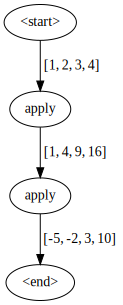

<trace object>

In [5]:
range(1, 5) | trace(iden()) | apply(lambda x: x**2) | apply(lambda x: x - 6)

Sweet. Let's combine the operations first, before feeding it input:

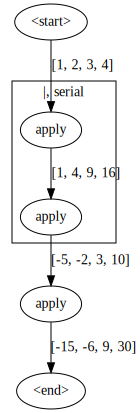

<trace object>

In [6]:
range(1, 5) | trace(iden()) | (apply(lambda x: x**2) | apply(lambda x: x - 6)) | apply(lambda x: x*3)

It knows, and automatically box the operations in. You can also put `trace()` wherever you like:

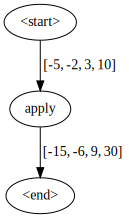

<trace object>

In [7]:
range(1, 5) | (apply(lambda x: x**2) | apply(lambda x: x - 6)) | trace(iden()) | apply(lambda x: x*3)

You can go wild with this. This is an example with `.all()`, `|`, and `op()`:

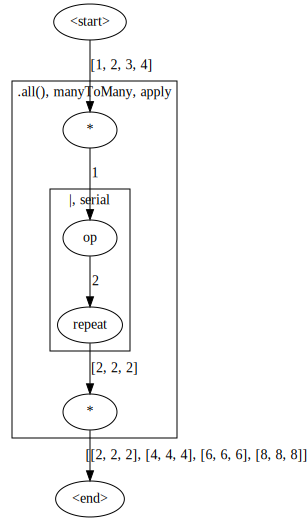

<trace object>

In [8]:
range(1,5) | trace(iden()) | (op()*2 | repeat(3)).all()

You can limit the depth of the graph, like this:

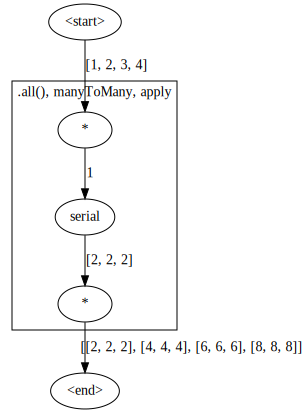

<trace object>

In [9]:
range(1,5) | trace(iden(), 1) | (op()*2 | repeat(3)).all()

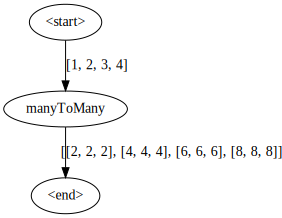

<trace object>

In [10]:
range(1,5) | trace(iden(), 0) | (op()*2 | repeat(3)).all()

If the graphs are too small/big, you can adjust the settings, like this:

In [11]:
settings.svgScale = 0.7 # times graphviz's default size. Defaulted to 0.7

Let's see some more complex examples:

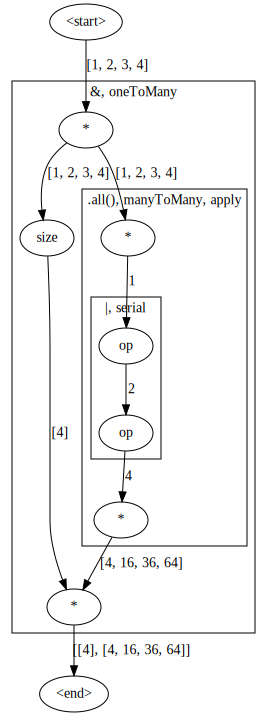

<trace object>

In [12]:
range(1,5) | trace(iden()) | (shape() & (op()*2 | op()**2).all())

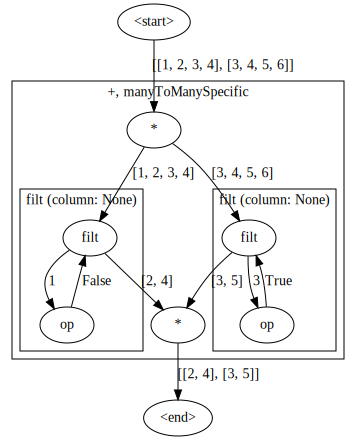

<trace object>

In [13]:
[range(1, 5), range(3, 7)] | trace(iden()) | (filt(op() % 2 == 0) + filt(op() % 2 == 1))

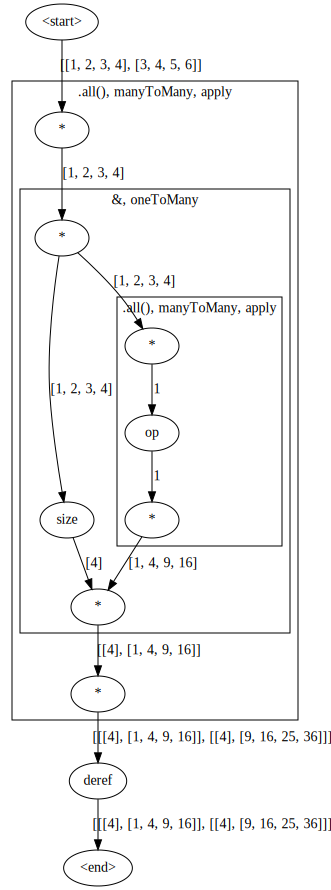

<trace object>

In [14]:
[range(1, 5), range(3, 7)] | trace(iden()) | ((shape() & (op()**2).all())).all() | deref()

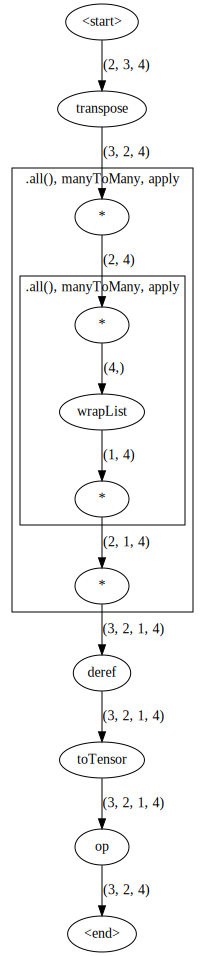

<trace object>

In [15]:
a = torch.randn(2, 3, 4) | deref(ignoreTensors=False)
a | trace() | transpose() | unsqueeze(2) | deref() | toTensor() | op().squeeze()

As you can see, this can be extremely useful in debugging stuff.

## Infinity and nested traces

The way `trace()` works is by `deref`-ing every part of the stream. This means you can't really handle infinite streams. There is a workaround for this though. Say we have this infinite stream:

In [16]:
range(1, 5) | repeatFrom() | apply(op()**2) | head(10) | deref()

[1, 4, 9, 16, 1, 4, 9, 16, 1, 4]

So, we can set what infinity means inside `cliSettings`, which will be picked up by clis that can potentially produce infinite streams and limit them:

In [17]:
with settings.cli.context(inf=21):
    range(1, 5) | trace() | repeatFrom() | apply(lambda x: x**2) | head(10) | deref()

Because trace objects only displays their graph through calling `__repr__`, the code above wouldn't display anything because it's inside a block. To get the graph, do this:

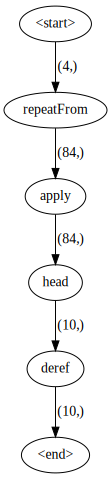

<trace object>

In [18]:
trace.last

This is sort of messy I get it, but there doesn't seem to be a way to robustly track infinite streams.

You can also put `trace()` inside of a relatively complex block. Let's grab an example from before:

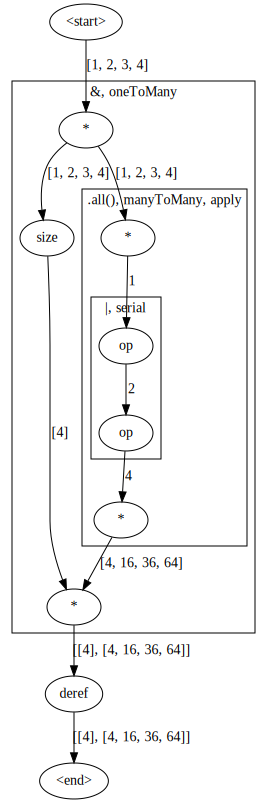

<trace object>

In [19]:
range(1,5) | trace(None) | (shape() & (op()*2 | op()**2).all()) | deref()

Now let's try to intercept in the middle:

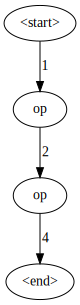

[[4], [<trace object>, 16, 36, 64]]

In [20]:
range(1,5) | (shape() & (trace(None) | op()*2 | op()**2).all()) | deref()

It works! If for some reason, it errors out, you can always do `trace.last` to see the best trace attempt. This is rare and I haven't been able to make it errors out, but logic says that it can in weird circumstances. Also, unlike `trace()` at the top level, notice how nested `trace()` are a part of the derefed object? This means that without actually forcing the execution to happen, you won't have any trace:

In [21]:
range(1,5) | (shape() & (trace(None) | op()*2 | op()**2).all())

<generator object oneToMany.__ror__ at 0x7f0007f4fd60>

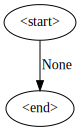

<trace object>

In [22]:
trace.last

Therefore, it's my recommendation to always do `deref()`, ignore the output (because it can potentially be long), then see the last trace:

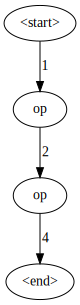

<trace object>

In [23]:
range(1,5) | (shape() & (trace(None) | op()*2 | op()**2).all()) | deref(); trace.last

Also very surprisingly, this works too, while I reason it shouldn't really work!

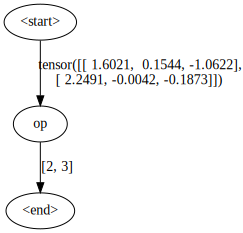

[<trace object>,
 tensor([[-0.4524, -0.7593,  0.6081,  0.3310,  0.6469],
         [ 1.0787,  0.2763, -0.3129, -0.9712,  0.4768],
         [ 1.0288, -0.7199, -0.2076,  0.3306, -1.5635],
         [-1.1242,  1.6919,  0.7447, -0.1250, -0.1216]])]

In [24]:
[torch.randn(2, 3), torch.randn(4, 5)] | ((trace(None) | op().shape) + iden()) | deref()

No idea how that works, but nice

## Gotchas

There aren't any other gotchas, as far as I'm aware of. Sometimes the clis will be replaced by a version that is guaranteed to return the same result, but are slightly different, to make tracing code simpler. Examples may include `applyMp` changing into `apply` (will not work if `trace()` is nested inside of `applyMp` tho, and there be dragons if you try to do so). But you need not worry about this too much.